In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [3]:
data_train = pd.read_csv(TRAIN_DATASET_PATH)
data_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [4]:
y = data_train['mean_exam_points']

In [5]:
X = data_train.drop(['mean_exam_points'], axis = 1)

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.25
)

In [7]:
BASE_FEATURE_NAMES = data_train.columns.tolist()

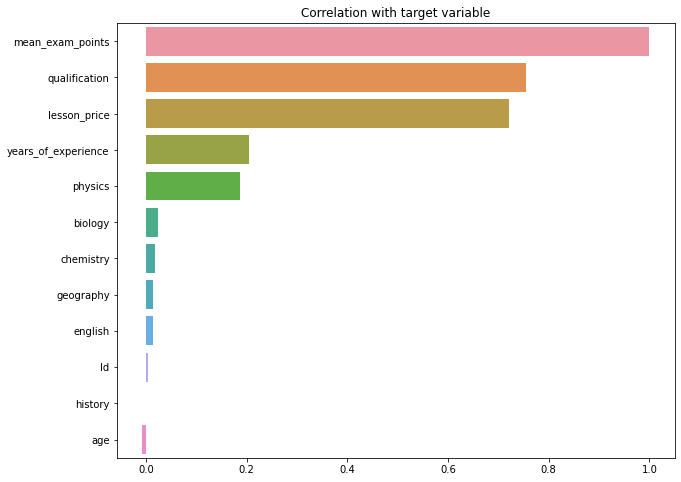

In [8]:
corr_with_target = data_train[BASE_FEATURE_NAMES + ['mean_exam_points']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Высокая корреляция у 2 факторов - квалификации и стоимости урока. 

#### Включу 2 признака - квалификацию, стоимость урока, года опыта в отдельный список  NUM_FEATURES

In [9]:
NUM_FEATURES = ['qualification', 'lesson_price', 'years_of_experience', 'physics']

In [10]:
X_train_num = X_train.copy()
X_train_num_ft = X_train_num[NUM_FEATURES]
X_test_num = X_test.copy()
X_test_num_ft = X_test_num[NUM_FEATURES]
#data_train_st[NUM_FEATURES] = calc_std_feat(data_train_st[NUM_FEATURES])
#data_train_st_num_ft = calc_std_feat(data_train_num_ft)
#data_train_st_num_features = data_train_st[NUM_FEATURES]

In [11]:
X_train_num_ft

,qualification,lesson_price,years_of_experience,physics
4355,1.0,1200.0,2.0,0.0
2308,1.0,1450.0,2.0,0.0
5178,2.0,1800.0,2.0,0.0
7354,1.0,1200.0,3.0,1.0
286,2.0,2150.0,2.0,0.0
...,...,...,...,...
8416,1.0,1750.0,0.0,0.0
1980,1.0,1250.0,1.0,0.0
3672,2.0,1400.0,1.0,0.0
5834,1.0,1300.0,5.0,0.0


In [12]:
X_test_num_ft

,qualification,lesson_price,years_of_experience,physics
4863,2.0,1500.0,0.0,0.0
7691,3.0,2200.0,0.0,0.0
7069,1.0,1000.0,2.0,1.0
1877,3.0,2950.0,5.0,1.0
9870,2.0,1750.0,2.0,1.0
...,...,...,...,...
7995,2.0,1600.0,8.0,1.0
2078,1.0,1400.0,0.0,1.0
4034,3.0,2950.0,4.0,0.0
2873,3.0,1800.0,1.0,0.0


In [13]:
X_train_num_ft_np = np.array(X_train_num_ft)
X_test_num_ft_np = np.array(X_test_num_ft)

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [15]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [16]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [17]:
def bias(y, z):
    return (y - z)

In [18]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [20]:
n_trees = 15

coefs = [1] * n_trees

max_depth = 4

eta = 0.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train_num_ft_np, X_test_num_ft_np, y_train, y_test, coefs, eta)

In [21]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [22]:
evaluate_alg(X_train_num_ft_np, X_test_num_ft_np, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.5 на тренировочной выборке: 37.94823559860239
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.5 на тестовой выборке: 41.756457669582915


In [23]:
train_prediction = gb_predict(X_train_num_ft_np, trees, coefs, eta)

In [24]:
data_test = pd.read_csv(TEST_DATASET_PATH)
data_test_np = data_test.copy()
data_test_np_ft = data_test_np[NUM_FEATURES]
data_test_np_ft  = np.array(data_test_np_ft)

In [25]:
data_test_np_ft

array([[1.00e+00, 1.05e+03, 3.00e+00, 0.00e+00],
       [2.00e+00, 1.85e+03, 3.00e+00, 0.00e+00],
       [1.00e+00, 1.55e+03, 1.00e+00, 1.00e+00],
       ...,
       [1.00e+00, 1.10e+03, 5.00e+00, 0.00e+00],
       [2.00e+00, 1.75e+03, 0.00e+00, 0.00e+00],
       [2.00e+00, 2.00e+03, 5.00e+00, 1.00e+00]])

In [26]:
test_prediction = gb_predict(data_test_np_ft, trees, coefs, eta)

In [27]:
predictions = pd.DataFrame(index = data_test['Id'])
predictions['mean_exam_points'] = np.array(test_prediction)
predictions

,mean_exam_points
Id,
10000,54.742255
10001,64.334982
10002,48.822753
10003,91.160433
10004,90.170366
...,...
19995,41.739648
19996,79.693176
19997,51.349069


In [28]:
predictions.to_csv('predictions_Iranti_v10.csv')